<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de bibliotecas

In [3998]:
# !pip install docplex

In [3999]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import linprog
from sklearn.metrics import r2_score
# from docplex.mp.model import Model
import warnings

## Parâmetros de Entrada

In [4000]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17
Sor = 0.18
Sgc = 0.05

## Ajuste PVT

In [4001]:
pvt=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_pvt.xlsx')
pvt.head()

,p,Rs_ext,Bo_ext,Bg,viso,visg,co,Rs,Bo
0,35.49,31.80,1.198,0.0346,2.05,0.0109,0.000162,31.80,1.198
1,41.82,34.66,1.200,0.0291,1.99,0.0113,0.000162,34.66,1.200
2,49.20,38.02,1.210,0.0245,1.91,0.0117,0.000162,38.02,1.210
3,59.75,42.83,1.230,0.0199,1.81,0.0123,0.000162,42.83,1.230
4,68.54,46.85,1.240,0.0172,1.73,0.0128,0.000162,46.85,1.240


0.0012078946324729843 1.1537752108328592


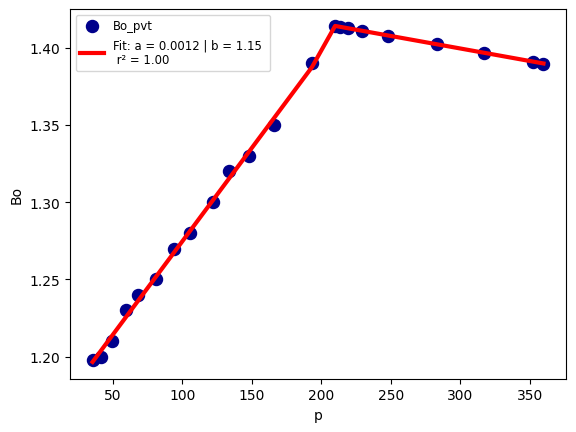

In [4002]:
## Ajuste Bo

p_pvt=pvt["p"].values
bo_pvt=pvt["Bo"].values

## Escolhento intervalo de ajuste com p < pb
p_adj = p_pvt[(p_pvt<pb)]
bo_adj = bo_pvt[(p_pvt<pb)]

## Ajuste de uma reta por mínimos quadrados com p < pb
def func_bob(p, a, b):
    return a*p+b

initialGuess=[1,1]
popt, pcov = curve_fit(func_bob, p_adj, bo_adj, initialGuess)
bo_a, bo_b = popt[0], popt[1]
print(bo_a, bo_b)

## Função Bo
def func_bo(p, a, b):
    bo = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          bo[i] = a * p[i] + b
        else:
          bo[i] = bob - co * (p[i] - pb)
    return bo

## Valores previstos
bo_prev = func_bo(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(bo_pvt, bo_prev)

## Gráfico comparativo Bo x Bo_prev
plt.scatter(p_pvt, bo_pvt, label="Bo_pvt", color="darkblue", s=75)
# plt.scatter(p_adj, bo_adj, label="Bo_adj", color="darkorange", s=75)
plt.plot(p_pvt, bo_prev, label=f"Fit: a = {popt[0]:0.4f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("Bo")
plt.show()

1.5059386354307656 -1.0574564793491976


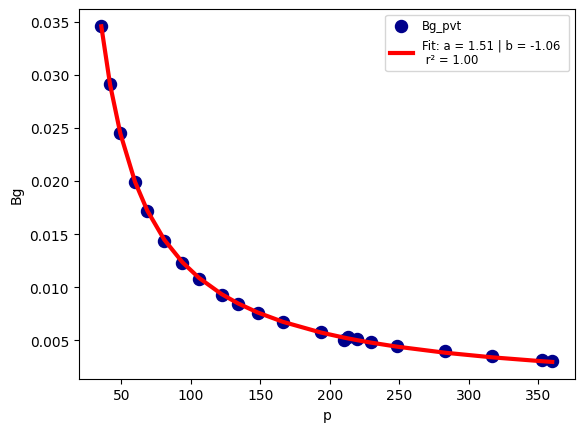

In [4003]:
## Ajuste Bg

bg_pvt=pvt["Bg"].values

## Ajuste de uma reta por mínimos quadrados
def func_bg(p, a, b):
    return a*p**(b)

initialGuess=[1,-1]
popt, pcov = curve_fit(func_bg, p_pvt, bg_pvt, initialGuess)
bg_a, bg_b = popt[0], popt[1]
print(bg_a, bg_b)

## Valores previstos
bg_prev = func_bg(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(bg_pvt, bg_prev)

## Gráfico comparativo Bg x Bg_prev
plt.scatter(p_pvt, bg_pvt, label="Bg_pvt", color="darkblue", s=75)
plt.plot(p_pvt, bg_prev, label=f"Fit: a = {popt[0]:0.2f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("Bg")
plt.show()

0.46549860654998376 15.011424226022424


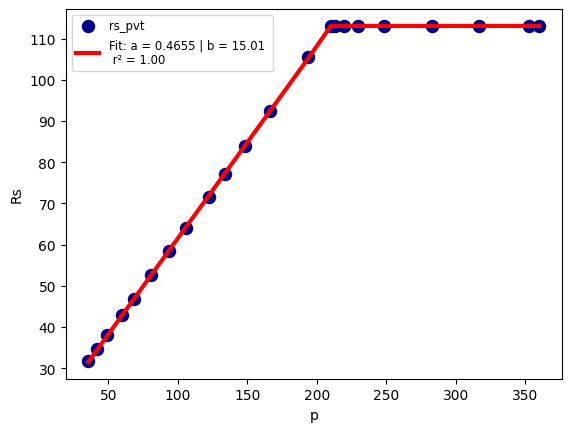

In [4004]:
## Ajuste Rs

rs_pvt=pvt["Rs"].values

## Escolhento intervalo de ajuste com p < pb
p_adj = p_pvt[(p_pvt<pb)]
rs_adj = rs_pvt[(p_pvt<pb)]

## Ajuste de uma reta por mínimos quadrados com p < pb
def func_rsb(p, a, b):
    return a*p+b

initialGuess=[1,1]
popt, pcov = curve_fit(func_rsb, p_adj, rs_adj, initialGuess)
rs_a, rs_b = popt[0], popt[1]
print(rs_a, rs_b)

## Função rs
def func_rs(p, a, b):
    rs = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          rs[i] = a * p[i] + b
        else:
          rs[i] = Rsi
    return rs

## Valores previstos
rs_prev = func_rs(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(rs_pvt, rs_prev)

## Gráfico comparativo rs x rs_prev
plt.scatter(p_pvt, rs_pvt, label="rs_pvt", color="darkblue", s=75)
# plt.scatter(p_adj, rs_adj, label="rs_adj", color="darkorange", s=75)
plt.plot(p_pvt, rs_prev, label=f"Fit: a = {popt[0]:0.4f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("Rs")
plt.show()

-0.6694676521799026 4.524634377653334


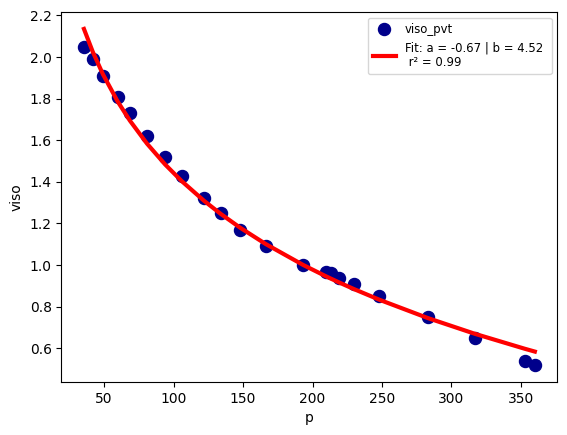

In [4005]:
## Ajuste Viso

viso_pvt=pvt["viso"].values

## Ajuste de uma reta por mínimos quadrados
def func_viso(p, a, b):
    return a*np.log(p)+b

initialGuess=[-1,1]
popt, pcov = curve_fit(func_viso, p_pvt, viso_pvt, initialGuess)

## Valores previstos
viso_prev = func_viso(p_pvt, *popt)
viso_a, viso_b = popt[0], popt[1]
print(viso_a, viso_b)

## Métrica de desempenho
r2 = r2_score(viso_pvt, viso_prev)

## Gráfico comparativo viso x viso_prev
plt.scatter(p_pvt, viso_pvt, label="viso_pvt", color="darkblue", s=75)
plt.plot(p_pvt, viso_prev, label=f"Fit: a = {popt[0]:0.2f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("viso")
plt.show()

5.532705804609023e-05 0.008974925072326187


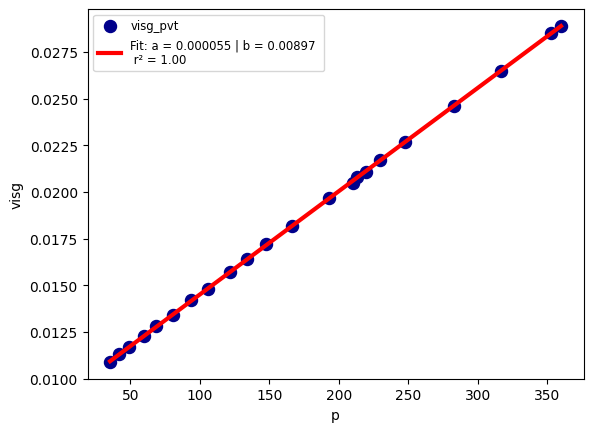

In [4006]:
## Ajuste visg

visg_pvt=pvt["visg"].values

## Ajuste de uma reta por mínimos quadrados com p < pb
def func_visg(p, a, b):
    return a*p+b

initialGuess=[1,1]
popt, pcov = curve_fit(func_visg, p_pvt, visg_pvt, initialGuess)
visg_a, visg_b = popt[0], popt[1]
print(visg_a, visg_b)

## Valores previstos
visg_prev = func_visg(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(visg_pvt, visg_prev)

## Gráfico comparativo visg x visg_prev
plt.scatter(p_pvt, visg_pvt, label="visg_pvt", color="darkblue", s=75)
plt.plot(p_pvt, visg_prev, label=f"Fit: a = {popt[0]:0.6f} | b = {popt[1]:0.5f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("visg")
plt.show()

## Ajuste KREL

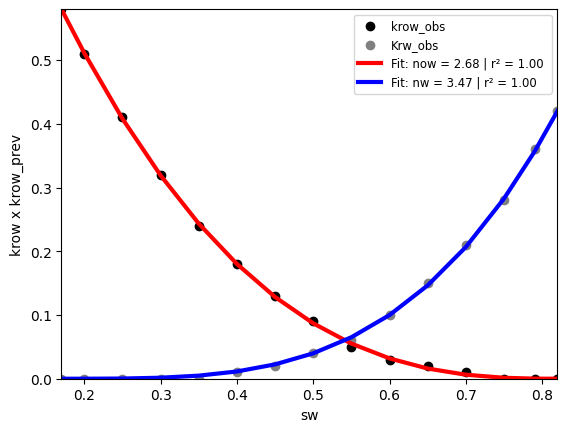

In [4007]:
## Permeabilidade Relativa Óleo-Água

krow_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_krel.xlsx', sheet_name="krow")

sw = krow_df["sw"].values
krow_obs = krow_df["krow"].values
krw_obs = krow_df["krw"].values

krow_max = krow_obs[0]
krw_max = krw_obs[-1]

def f_krow(sw, now):
  return krow_max*((1-Sor-sw)/(1-Sor-Swi))**now

def f_krw(sw, nw):
  return krw_max*((sw-Swi)/(1-Sor-Swi))**nw

## Ajuste krow
initialGuess1=[2]
popt1,pcov1 = curve_fit(f_krow, sw, krow_obs, initialGuess1)
krow_pred = f_krow(sw, *popt1)
r2_1 = r2_score(krow_obs, krow_pred)
now = popt1[0]

## Ajuste krw
initialGuess2=[2]
popt2,pcov2 = curve_fit(f_krw, sw, krw_obs, initialGuess2)
krw_pred = f_krw(sw, *popt2)
r2_2 = r2_score(krw_obs, krw_pred)
nw = popt2[0]

plt.scatter(sw, krow_obs, label="krow_obs", color="black")
plt.scatter(sw, krw_obs, label="Krw_obs", color="grey")
plt.plot(sw, krow_pred, label=f"Fit: now = {now:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_1:0.2f} ", color="red", linewidth=3)
plt.plot(sw, krw_pred, label=f"Fit: nw = {nw:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:0.2f}", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("sw")
plt.ylabel("krow x krow_prev")
plt.xlim(sw[0], sw[-1])
plt.ylim(0, krow_max)
plt.show()

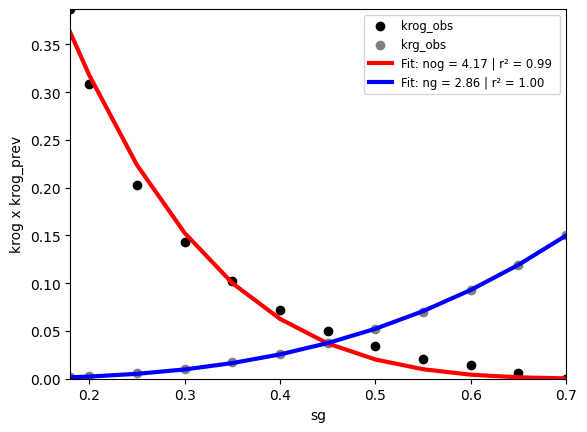

In [4008]:
## Permeabilidade Relativa Gás-Óleo

krog_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_krel.xlsx', sheet_name="krog").iloc[1:,]

sg = krog_df["sg"].values
krog_obs = krog_df["krog"].values
krg_obs = krog_df["krg"].values

krog_max = krog_obs[0]
krg_max = krg_obs[-1]

def f_krog(sg, nog):
  return krog_max*((1-Sor-sg)/(1-Sor-Swi))**nog

def f_krg(sg, ng):
  return krg_max*((sg-Sgc)/(1-Sor-Swi))**ng

## Ajuste krog
initialGuess1=[3]
popt1,pcov1 = curve_fit(f_krog, sg, krog_obs, initialGuess1)
krog_pred = f_krog(sg, *popt1)
r2_1 = r2_score(krog_obs, krog_pred)
nog = popt1[0]

## Ajuste krg
initialGuess2=[3]
popt2,pcov2 = curve_fit(f_krg, sg, krg_obs, initialGuess2)
krg_pred = f_krg(sg, *popt2)
r2_2 = r2_score(krg_obs, krg_pred)
ng = popt2[0]

plt.scatter(sg, krog_obs, label="krog_obs", color="black")
plt.scatter(sg, krg_obs, label="krg_obs", color="grey")
plt.plot(sg, krog_pred, label=f"Fit: nog = {nog:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_1:0.2f} ", color="red", linewidth=3)
plt.plot(sg, krg_pred, label=f"Fit: ng = {ng:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:0.2f}", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("sg")
plt.ylabel("krog x krog_prev")
plt.xlim(sg[0], sg[-1])
plt.ylim(0, krog_max)
plt.show()

## Módulo de Ajuste de Histórico

### Importação Histórico - Campo

In [4009]:
df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_hist-m.xlsx').iloc[1:,:]
# df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_hist-m.xlsx').iloc[1:49,:]
df.head()

,Date,Press,Np,Gp,Wp,Winj
1,2013-06-30,332,0,0,0,0
2,2013-07-31,331,61938,6858068,0,0
3,2013-08-31,329,124403,13532213,0,0
4,2013-09-30,328,182423,20112443,0,0
5,2013-10-31,327,244857,26856741,0,0


In [4010]:
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
df["qo"]=(df["Np"].diff()/df["dt"]).fillna(0)
df["qg"]=(df["Gp"].diff()/df["dt"]).fillna(0)
df["qw"]=(df["Wp"].diff()/df["dt"]).fillna(0)
df["qwi"]=(df["Winj"].diff()/df["dt"]).fillna(0)
# df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
# df["dp"]= df["Press"].iloc[0]-df["Press"]
# df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.tail()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
128,2024-01-31,305,24757936,2793256452,4393983,36864922,3867.0,31.0,9053.0,986609.0,6446.0,19374.0
129,2024-02-29,306,25022300,2822363056,4583991,37475894,3896.0,29.0,9116.0,1003676.0,6552.0,21068.0
130,2024-03-31,307,25304090,2853787229,4789676,38123794,3927.0,31.0,9090.0,1013683.0,6635.0,20900.0
131,2024-04-30,308,25567400,2883725639,4991816,38702374,3957.0,30.0,8777.0,997947.0,6738.0,19286.0
132,2024-05-31,309,25832419,2913898931,5206739,39341191,3988.0,31.0,8549.0,973332.0,6933.0,20607.0


In [4011]:
# EBM
# F/(Eo+mEg+(1+m)Efw)=N+We/(Eo+mEg+(1+m)Efw)
# We = F-N*(Eo+mEg+(1+m)Efw)

# Bt=Bo+(Rsi-Rs)*Bg
# F = Np*(Bt+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rsi-Rs)*Bg+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rp-Rs)*Bg)+(Wp-Winj)*Bw

# Eo= Bt-Bti

# Eg= Boi*(Bg/Bgi-1)

# Efw = Boi*((cf+cw.Swi)/(1-Swi))*∆p
# Efw = Boi*((cf+cw.Swi)/(1-Swi))*(pi-p)

p = df["Press"].values

bo = func_bo(p, bo_a, bo_b)
df["Bo"]=bo

bg = func_bg(p, bg_a, bg_b)
df["Bg"]=bg

rs = func_rs(p, rs_a, rs_b)
df["Rs"]=rs

uo = func_viso(p, viso_a, viso_b)
df["Viso"]=uo

ug = func_visg(p, visg_a, visg_b)
df["Visg"]=ug

df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)

# df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
# df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["F"] = df["Np"]*(df["Bo"]+(df["Rp"]-df["Rs"])*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
# df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eo"] = df["Bo"]-df["Bo"].iloc[0]+(df["Rs"].iloc[0]-df["Rs"])*df["Bg"]
# df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Eg"] = df["Bo"].iloc[0]*((df["Bg"]/df["Bg"].iloc[0])-1)
# df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])
df["Efw"] = (1+m)*df["Bo"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])

df.head()

/usr/local/lib/python3.10/dist-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,Bo,Bg,Rs,Viso,Visg,Rp,F,Eo,Eg,Efw
1,2013-06-30,332,0,0,0,0,0.0,0.0,0.0,0.0,...,1.394241,0.003249,113.06,0.638284,0.027344,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,...,1.394403,0.003260,113.06,0.640304,0.027288,110.724725,85895.010882,0.000162,0.004455,0.000103
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,...,1.394727,0.003281,113.06,0.644361,0.027178,108.777224,171760.217854,0.000486,0.013447,0.000308
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,...,1.394889,0.003291,113.06,0.646399,0.027122,110.251684,252773.623635,0.000648,0.017986,0.000410
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,...,1.395051,0.003302,113.06,0.648443,0.027067,109.683370,338857.869258,0.000810,0.022553,0.000513


### Ajuste de Histórico

In [4012]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
# p_med=train["p_med"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
gp=train["Gp"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values
qo=train["qo"].values
qg=train["qg"].values
qw=train["qw"].values
qwi=train["qwi"].values

Estimativa de N: 183.81
Estimativa de Wi: 100.00
Estimativas de J: 100.00
desvio (MMm³): 0.2055
r²: 0.75


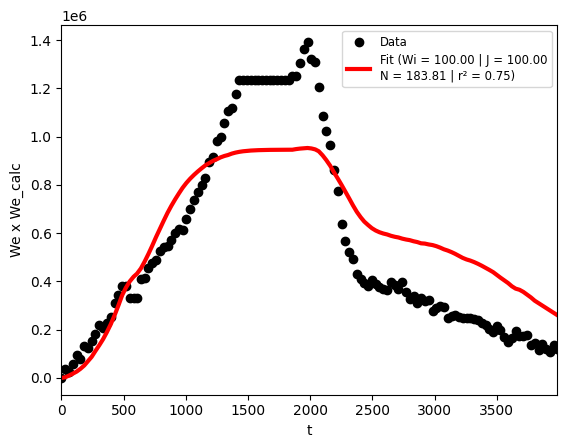

In [4013]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m):
    N = x[0]  # N é constante
    Wi = x[1]  # Wei é constante
    J = x[2]  # J é constante
    Wei = (cf+cw)*Wi*p[0]*10**6
    Wen = np.zeros(len(t))
    pa_med = np.zeros(len(t))
    pa_med[0] = p[0]
    for i in range(1,len(t)):
      pa_med[i-1]=p[0]*(1-(Wen[i-1]/Wei))
      Wen[i]=Wen[i-1]+(Wei/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
    We_EBM = F - (N*10**6) * (Eo + m * Eg + Efw)
    return np.mean(((We_EBM - Wen)/10**6) ** 2)**0.5
    # return np.sum((We_EBM - Wen) ** 2)

# Chute inicial para N, Wi e J
x0 = np.array([130] + [100] + [10])

# Limites para N, Wi e J
bounds = [(10, 300)] + [(100, 1000)] + [(1, 100)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds)

N_est = result.x[0]
Wi_est = result.x[1]
J_est = result.x[2]

print(f"Estimativa de N: {N_est:0.2f}")
print(f"Estimativa de Wi: {Wi_est:0.2f}")
print(f"Estimativas de J: {J_est:0.2f}")

Wei_est = (cf+cw)*Wi_est*p[0]*10**6
# print(Wei_est)
Wen = np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
for i in range(1,len(t)):
  pa_med[i-1] = p[0]*(1-(Wen[i-1]/Wei_est))
  Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
pa_med[len(t)-1] = p[0]*(1-(Wen[len(t)-1]/Wei_est))
We_EBM = F - (N_est*10**6) * (Eo + m * Eg + Efw)
print(f"desvio (MMm³): {np.mean(((We_EBM - Wen)/10**6) ** 2)**0.5:0.4f}")

r2_2 = r2_score(We_EBM, Wen)
print(f"r²: {r2_2:0.2f}")

plt.scatter(t, We_EBM, label="Data", color="black")
plt.plot(t, Wen, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("We x We_calc")
plt.xlim(0, df.iloc[-1, 6])
plt.show()

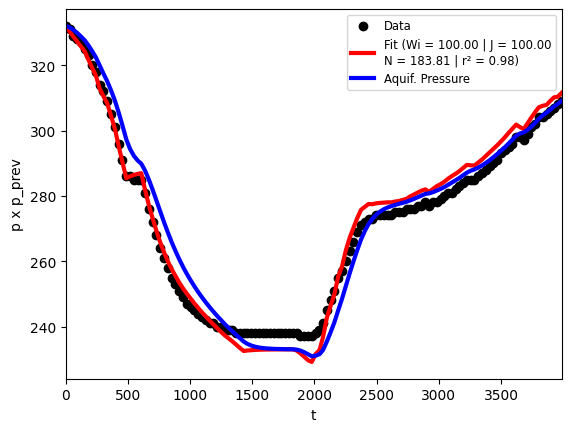

In [4014]:
## Previsao de pressao

p_prev=np.zeros(len(t))
we_aquif=np.zeros(len(t))
ppa_med=np.zeros(len(t))
we_ebm=np.zeros(len(t))

for i in range(len(t)):
  if i == 0:
    p_prev[i]=p[0]
    we_aquif[i]=0
    ppa_med[i]=p[0]
    we_ebm[i]=0
  else:
    # Função objetivo
    def obj_f(x, m, N, Wei, J):
      pn = x[0]  # pressao prevista

      ## Aquifero
      ppa_med[i-1]=p[0]*(1-(we_aquif[i-1]/Wei))
      we_aquif[i]=we_aquif[i-1]+(Wei/p[0])*(ppa_med[i-1]-pn)*(1-np.exp(-J*p[0]*dt[i]/Wei))

      ## EBM
      if pn < pb:
        bop = bo_a * pn + bo_b
        rsp = rs_a * pn + rs_b
      else:
        bop = bob - co * (pn - pb)
        rsp = Rsi
      bgp = bg_a*pn**(bg_b)
      fp=npp[i]*(bop+(rp[i]-rsp)*bgp)+(wp[i]-winj[i])*Bw
      eop=bop-bo[0]+(Rsi-rsp)*bgp
      egp=bo[0]*((bgp/bg[0])-1)
      efwp=(1+m)*bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
      we_ebm[i]=fp-N*(eop+m*egp+efwp)*10**6

      return (we_ebm[i] - we_aquif[i]) ** 2

    x0 = [p_prev[i-1]]
    result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))
    p_prev[i]=result.x[0]

  ppa_med[i]=p[0]*(1-(we_aquif[i]/Wei_est))

r2_2 = r2_score(p, p_prev)
# print(p_prev)

plt.scatter(t, p, label="Data", color="black")
plt.plot(t, p_prev, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.plot(t, ppa_med, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, df.iloc[-1, 6])
plt.show()

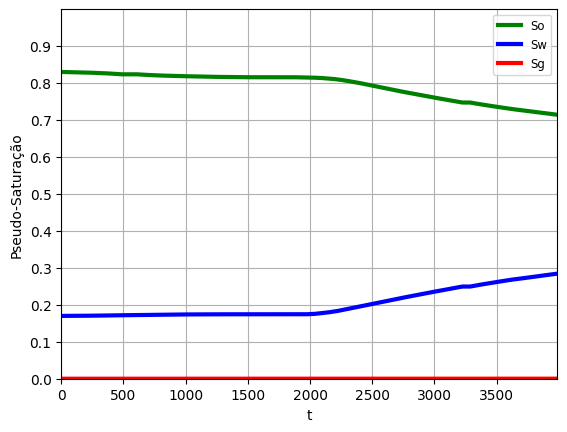

In [4015]:
## Saturacoes de fluidos

So = np.zeros(len(t))
Sw = np.zeros(len(t))
Sg = np.zeros(len(t))
cct = np.zeros(len(t))
Vpp = np.zeros(len(t))
Vp = (N_est*10**6) * bo[0] / (1 - Swi)
G = ((N_est*10**6) * Rsi + m * (N_est*10**6) * bo[0] / bg[0])
# print(G)

for i in range(len(t)):
  cct[i] = (1 + (Swi * cw / (1 - Swi) + cf) * (p[i] - p[0]))
  Vpp[i] = Vp * (1 + cf * (p[i] - p[0]))
  So[i] = ((N_est*10**6) - npp[i]) *bo[0] / Vpp[i]
  Sw[i] = (Swi * Vp * (1 - cw * (p[i] - p[0])) + ((winj[i] - wp[i] + Wen[i]) * Bw)) / Vpp[i]
  Sg[i] = bg[i] * (G - gp[i] - ((N_est*10**6) - npp[i]) * rs[i] - cct[i] * m * (N_est*10**6) * bo[0] / bg[0]) / Vpp[i]

# print(Sg)
fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.plot(t, So, label="So", color="green", linewidth=3)
plt.plot(t, Sw, label="Sw", color="blue", linewidth=3)
plt.plot(t, Sg, label="Sg", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, df.iloc[-1, 6])
plt.show()

### Importação Histórico - Poço

In [4016]:
## Importação do histórico por poço
wells_hist=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_hist_well-m.xlsx')
wells_hist.head()

,well,Date,BHP,Np,Gp,Wp,Winj
0,NA1A,2013-06-30,324,0,0,0,0
1,NA1A,2013-07-31,256,61938,6858068,0,0
2,NA1A,2013-08-31,262,124403,13532213,0,0
3,NA1A,2013-09-30,248,182423,20112443,0,0
4,NA1A,2013-10-31,249,244857,26856741,0,0


In [4017]:
wells = wells_hist["well"].drop_duplicates().values.astype(str)
wells_prod = wells[~np.char.startswith(wells, 'INJ')]
wells_inj = wells[np.char.startswith(wells, 'INJ')]

wells_prod, wells_inj

(array(['NA1A', 'NA2', 'NA3D', 'RJS19', 'PROD005', 'PROD008', 'PROD009',
        'PROD010', 'PROD012', 'PROD014', 'PROD021', 'PROD023A', 'PROD024A',
        'PROD025A'], dtype='<U8'),
 array(['INJ003', 'INJ005', 'INJ006', 'INJ007', 'INJ010', 'INJ015',
        'INJ017', 'INJ019', 'INJ021', 'INJ022', 'INJ023'], dtype='<U8'))

In [4018]:
len(wells_prod), len(wells_inj)

(14, 11)

In [4019]:
wells_prod_hist = []

for i in range(len(wells_prod)):
  wells_prod_hist.append(wells_hist[wells_hist['well'] == wells_prod[i]].copy())
  wells_prod_hist[i]["t"]=(wells_prod_hist[i]["Date"]-wells_prod_hist[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_prod_hist[i]["dt"]=wells_prod_hist[i]["t"].diff().fillna(0)
  wells_prod_hist[i]["qo"]=(wells_prod_hist[i]["Np"].diff()/wells_prod_hist[i]["dt"]).fillna(0)
  wells_prod_hist[i]["qg"]=(wells_prod_hist[i]["Gp"].diff()/wells_prod_hist[i]["dt"]).fillna(0)
  wells_prod_hist[i]["qw"]=(wells_prod_hist[i]["Wp"].diff()/wells_prod_hist[i]["dt"]).fillna(0)
  wells_prod_hist[i]["qwi"]=(wells_prod_hist[i]["Winj"].diff()/wells_prod_hist[i]["dt"]).fillna(0)
  # wells_prod_hist[i]["qb"]=wells_prod_hist[i]["qo"]+wells_prod_hist[i]["qw"]
  wells_prod_hist[i]["RAO"]=(wells_prod_hist[i]["qw"]/wells_prod_hist[i]["qo"]).fillna(1E-6)
  # wells_prod_hist[i]["RGO"]=(wells_prod_hist[i]["qg"]/wells_prod_hist[i]["qo"]).fillna(0)

wells_prod_hist[0]

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi,RAO
0,NA1A,2013-06-30,324,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001
1,NA1A,2013-07-31,256,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,0.0,0.0,0.000000
2,NA1A,2013-08-31,262,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,0.0,0.0,0.000000
3,NA1A,2013-09-30,248,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,0.0,0.0,0.000000
4,NA1A,2013-10-31,249,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,NA1A,2024-01-31,223,4352533,491925193,330103,0,3867.0,31.0,1488.0,161964.0,494.0,0.0,0.331989
128,NA1A,2024-02-29,229,4396062,496554028,346517,0,3896.0,29.0,1501.0,159615.0,566.0,0.0,0.377082
129,NA1A,2024-03-31,237,4442283,501390152,364125,0,3927.0,31.0,1491.0,156004.0,568.0,0.0,0.380952
130,NA1A,2024-04-30,230,4482903,506082482,381495,0,3957.0,30.0,1354.0,156411.0,579.0,0.0,0.427622


In [4020]:
wells_inj_hist = []

for i in range(len(wells_inj)):
  wells_inj_hist.append(wells_hist[wells_hist['well'] == wells_inj[i]].copy())
  wells_inj_hist[i]["t"]=(wells_inj_hist[i]["Date"]-wells_inj_hist[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_inj_hist[i]["dt"]=wells_inj_hist[i]["t"].diff().fillna(0)
  wells_inj_hist[i]["qo"]=(wells_inj_hist[i]["Np"].diff()/wells_inj_hist[i]["dt"]).fillna(0)
  wells_inj_hist[i]["qg"]=(wells_inj_hist[i]["Gp"].diff()/wells_inj_hist[i]["dt"]).fillna(0)
  wells_inj_hist[i]["qw"]=(wells_inj_hist[i]["Wp"].diff()/wells_inj_hist[i]["dt"]).fillna(0)
  wells_inj_hist[i]["qwi"]=(wells_inj_hist[i]["Winj"].diff()/wells_inj_hist[i]["dt"]).fillna(0)

wells_inj_hist[0]

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
1848,INJ003,2013-06-30,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1849,INJ003,2013-07-31,0,0,0,0,0,31.0,31.0,0.0,0.0,0.0,0.0
1850,INJ003,2013-08-31,0,0,0,0,0,62.0,31.0,0.0,0.0,0.0,0.0
1851,INJ003,2013-09-30,0,0,0,0,0,92.0,30.0,0.0,0.0,0.0,0.0
1852,INJ003,2013-10-31,0,0,0,0,0,123.0,31.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,INJ003,2024-01-31,347,0,0,0,5615925,3867.0,31.0,0.0,0.0,0.0,2697.0
1976,INJ003,2024-02-29,352,0,0,0,5691325,3896.0,29.0,0.0,0.0,0.0,2600.0
1977,INJ003,2024-03-31,349,0,0,0,5766996,3927.0,31.0,0.0,0.0,0.0,2441.0
1978,INJ003,2024-04-30,347,0,0,0,5846406,3957.0,30.0,0.0,0.0,0.0,2647.0


### Ajuste logRAOxNp

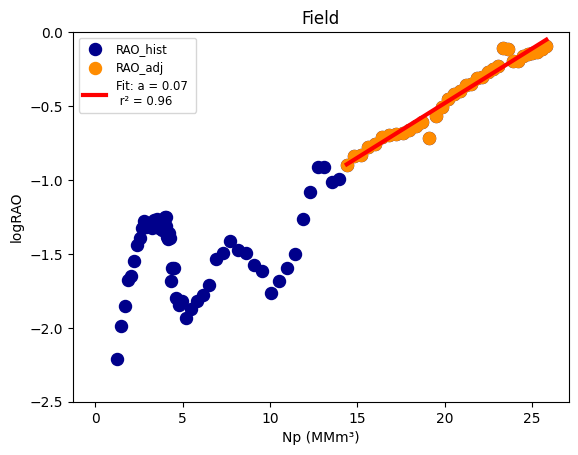

In [4021]:
## Ajuste LogRAOxNp - Campo

RAO = np.zeros(len(t))
for i in range(len(t)):
  if qo[i] == 0 or qw[i] == 0:
    RAO[i]=1E-6
  else:
    RAO[i]=qw[i]/qo[i]

## Escolhendo intervalo e retirando outliers para o ajuste
RAO_adj = RAO[(npp>1.4E7) & (np.log10(RAO)>-6)]
npp_adj = npp[(npp>1.4E7) & (np.log10(RAO)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(npp_adj, np.log10(RAO_adj), 1)
a = coeficientes[0]
b = coeficientes[1]

# Valores previstos
logRAO_prev = a*npp_adj + b

# Métrica de desempenho
r2 = r2_score(np.log10(RAO_adj), logRAO_prev)

plt.scatter(npp/10**6, np.log10(RAO), label="RAO_hist", color="darkblue", s=75)
plt.scatter(npp_adj/10**6, np.log10(RAO_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(npp_adj/10**6, logRAO_prev, label=f"Fit: a = {a*10**6:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title("Field")
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, 0)
plt.show()

In [4022]:
df["P_prev"]=p_prev
df["So"]=So
df["Sw"]=Sw
df["Sg" ]=Sg
df["We_ebm"]=We_EBM
df["We_aqui"]=Wen
df["Pa_med"]=ppa_med
df["cct"]=cct
df["Vpp"]=Vpp
df["RAO"]=RAO

df.head()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,P_prev,So,Sw,Sg,We_ebm,We_aqui,Pa_med,cct,Vpp,RAO
1,2013-06-30,332,0,0,0,0,0.0,0.0,0.0,0.0,...,332.000000,0.830000,0.170000,0.000000,0.000000,0.000000,332.000000,1.000000,3.087635e+08,0.000001
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,...,330.325778,0.829764,0.170026,0.000002,37255.016426,2667.868888,331.556003,0.999937,3.087471e+08,0.000001
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,...,328.716249,0.829570,0.170084,0.000006,25840.234485,9963.968155,330.802913,0.999812,3.087144e+08,0.000001
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,...,327.240379,0.829352,0.170127,0.000005,58213.645810,17770.796559,329.884295,0.999749,3.086980e+08,0.000001
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,...,325.699633,0.829114,0.170173,0.000009,95657.896977,26397.401907,328.774541,0.999686,3.086816e+08,0.000001


In [4023]:
## Inicialização dos parâmetros dos poços

aw = np.zeros(len(wells_prod))
bw = np.zeros(len(wells_prod))
BHPP = np.zeros(len(wells_prod))
BHPI = np.zeros(len(wells_inj))
IP = np.zeros(len(wells_prod))
II = np.zeros(len(wells_inj))

0.4875870040077862


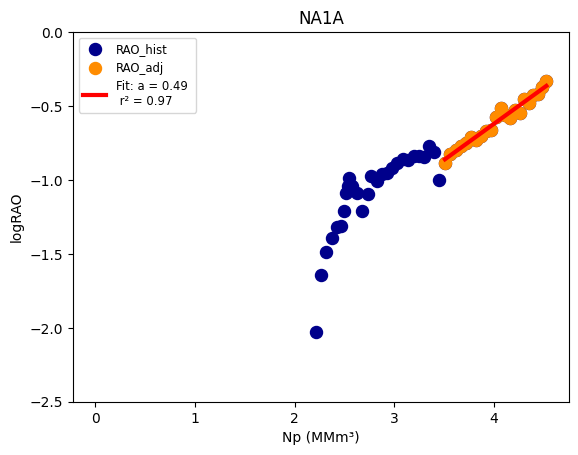

In [4024]:
## Ajuste LogRAOxNp - Well 0

w_num = 0

qow = wells_prod_hist[0]["qo"].values
qww = wells_prod_hist[0]["qw"].values
nppw = wells_prod_hist[0]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 3.5
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, 0)
plt.show()

1.4702945444976583


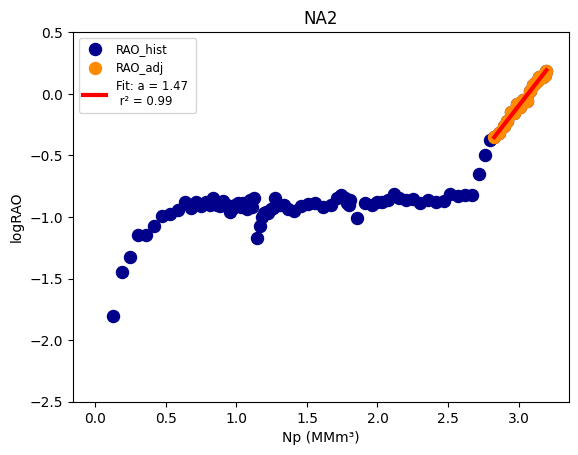

In [4025]:
## Ajuste LogRAOxNp - Well 1

w_num = 1

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 2.8
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

0.8395962379108004


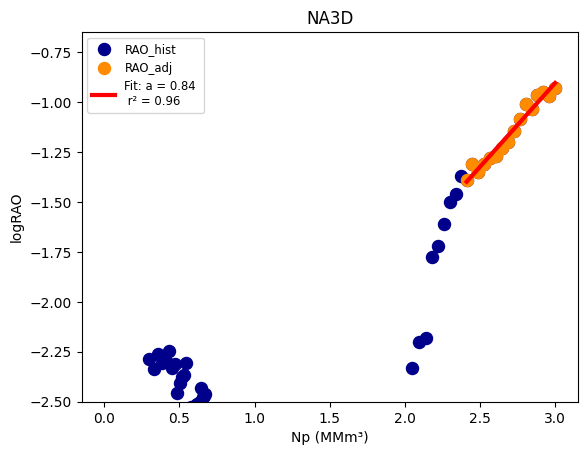

In [4026]:
## Ajuste LogRAOxNp - Well 2

w_num = 2

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 2.4
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.0737554062527874


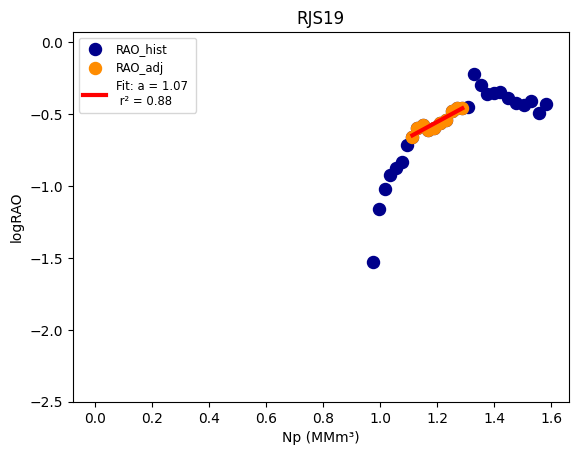

In [4027]:
## Ajuste LogRAOxNp - Well 3

w_num = 3

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.1
npp_max = 1.3
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# # Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# # Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.0300059658867033


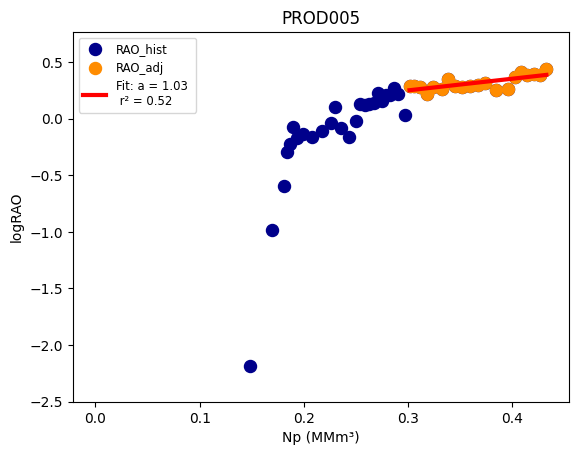

In [4028]:
## Ajuste LogRAOxNp - Well 4

w_num = 4

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.3
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.2954635228358717


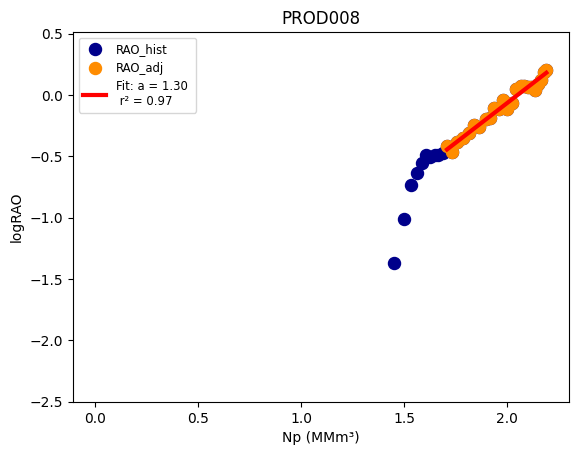

In [4029]:
## Ajuste LogRAOxNp - Well 5

w_num = 5

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.7
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

0.10686653688294459


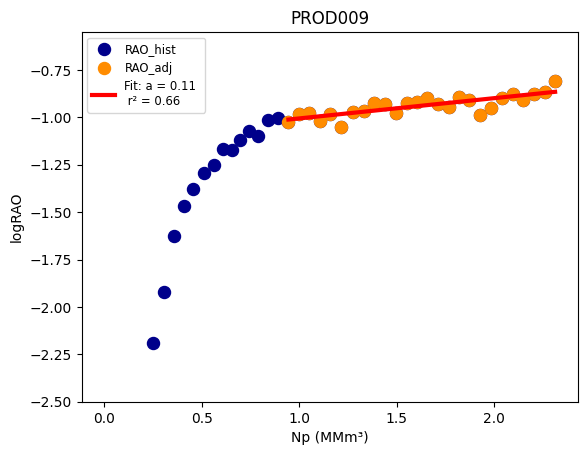

In [4030]:
## Ajuste LogRAOxNp - Well 6

w_num = 6

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.9
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

5.916694896694904


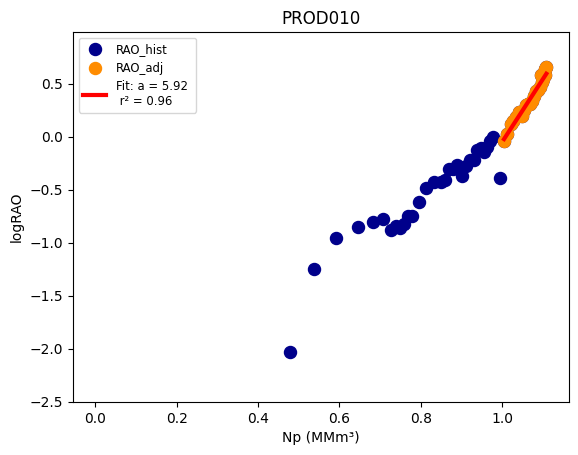

In [4031]:
## Ajuste LogRAOxNp - Well 7

w_num = 7

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.0
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

3.08479205973161


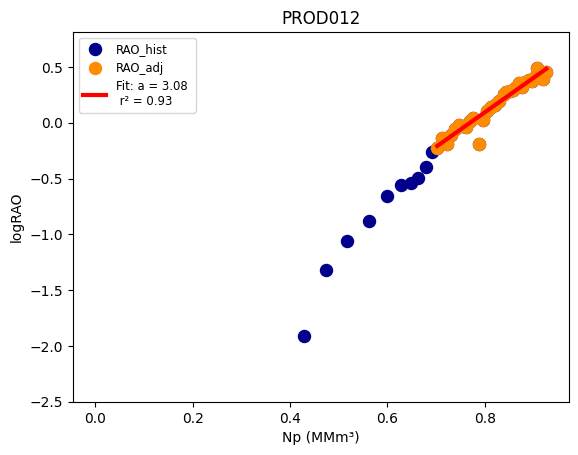

In [4032]:
## Ajuste LogRAOxNp - Well 8

w_num = 8

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.7
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.6716552194326306


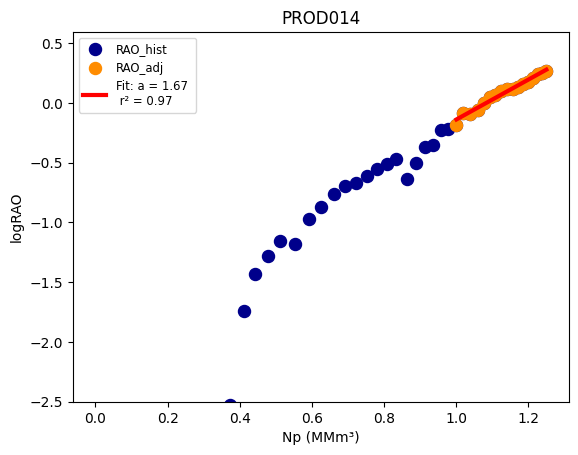

In [4033]:
## Ajuste LogRAOxNp - Well 9

w_num = 9

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.0
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.017887179733196


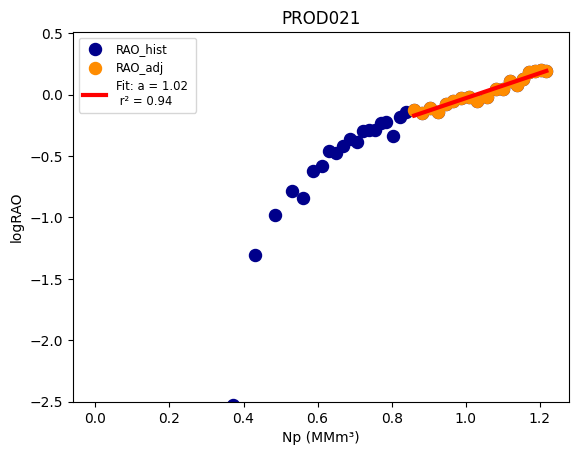

In [4034]:
## Ajuste LogRAOxNp - Well 10

w_num = 10

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.85
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.281812094363807


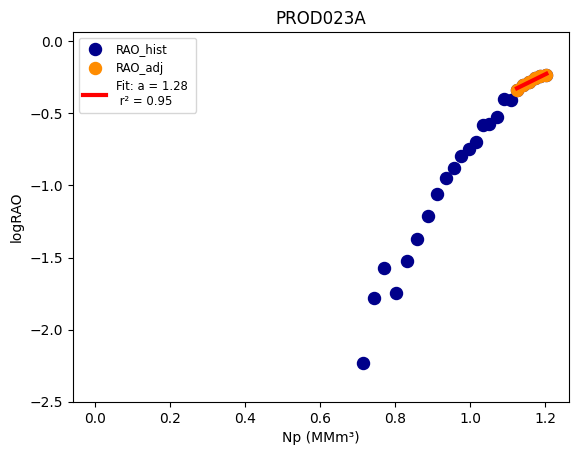

In [4035]:
## Ajuste LogRAOxNp - Well 11

w_num = 11

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.11
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

3.3219637238838144


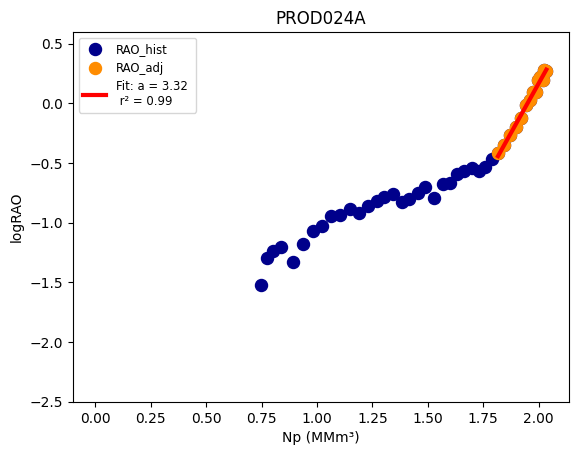

In [4036]:
## Ajuste LogRAOxNp - Well 12

w_num = 12

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.8
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.2751630559127751


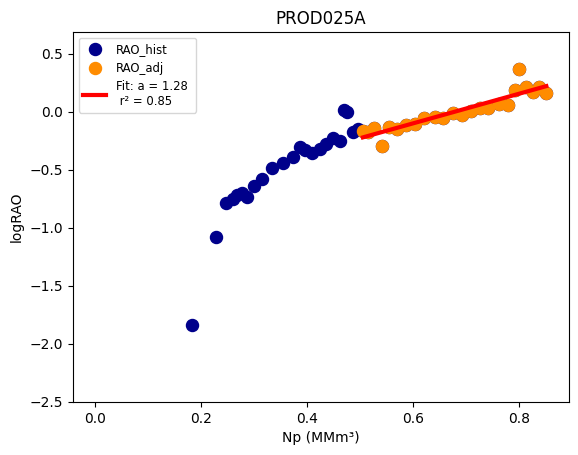

In [4037]:
## Ajuste LogRAOxNp - Well 13

w_num = 13

qow = wells_prod_hist[w_num]["qo"].values
qww = wells_prod_hist[w_num]["qw"].values
nppw = wells_prod_hist[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.5
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

In [4038]:
aw

array([0.487587  , 1.47029454, 0.83959624, 1.07375541, 1.03000597,
       1.29546352, 0.10686654, 5.9166949 , 3.08479206, 1.67165522,
       1.01788718, 1.28181209, 3.32196372, 1.27516306])

## Módulo Previsão

### Ajuste Ponto de Partida

In [4039]:
# Definição de BHP e IP

for w in range(len(wells_prod)):
  BHPP[w] = wells_prod_hist[w]["BHP"].values[-1]
  IP[w] = (wells_prod_hist[w]["qo"].values[-1]+wells_prod_hist[w]["qw"].values[-1])/(p_prev[-1]-BHPP[0])

BHPP, IP

(array([228., 267., 190., 195., 258., 289., 239., 300., 314., 217., 292.,
        185., 246., 314.]),
 array([24.50033039, 12.11844299, 16.83649292, 13.69910946,  8.33442324,
        12.15436722, 23.75789613,  4.86174689,  8.7655141 , 13.27999335,
        15.56716984,  9.6516453 ,  9.48399886, 12.3818874 ]))

In [4040]:
# Definição de BHP e II

for w in range(len(wells_inj)):
  BHPI[w] = wells_inj_hist[w]["BHP"].values[-1]
  II[w] = wells_inj_hist[w]["qwi"].values[-1]/(BHPI[0]-p_prev[-1])

BHPI, II

(array([351., 351., 347., 351., 352., 352., 340., 352., 352., 350., 350.]),
 array([ 68.52207697,  29.57641755,  19.24492923,  46.46637518,
         45.9346074 ,  24.8158298 , 117.77390243,  34.38764986,
        101.39039031,  17.57365906,  16.10496709]))

In [4041]:
verif=p_prev[-1]-BHPP
verif

array([ 83.50907795,  44.50907795, 121.50907795, 116.50907795,
        53.50907795,  22.50907795,  72.50907795,  11.50907795,
        -2.49092205,  94.50907795,  19.50907795, 126.50907795,
        65.50907795,  -2.49092205])

In [4042]:
## Ajustando BHP dos poços num 8 e 13 para evitar DD negativo
## Assumingo DD de 50 kgf/cm²

BHPP[8] = p_prev[-1]-50
IP[8] = (wells_prod_hist[8]["qo"].values[-1]+wells_prod_hist[8]["qw"].values[-1])/(p_prev[-1]-BHPP[8])

BHPP[13] = p_prev[-1]-50
IP[13] = (wells_prod_hist[13]["qo"].values[-1]+wells_prod_hist[13]["qw"].values[-1])/(p_prev[-1]-BHPP[13])

IP[8], IP[13]

(14.64, 20.68)

In [4043]:
## Ajuste de IP para corrigir ponto de partida da bruta

# Produtores
IP[0] = 23.0
IP[1] = 20.0
IP[2] = 12.0
IP[3] = 10.0
IP[4] = 12.0
IP[5] = 40.0
IP[6] = 27.0
IP[7] = 25.0
# IP[8] =
IP[9] = 12.0
IP[10] = 60.0
IP[11] = 6.0
IP[12] = 12.0
# IP[13] =

# Injetores
# II[0] =
# II[1] =
# II[2] =
# II[3] =
# II[4] =
# II[5] =
II[6] = 150.0
# II[7] =
II[8] = 120.0
II[9] = 20.0
II[10] = 18.5

In [4044]:
BHPP, IP

(array([228.        , 267.        , 190.        , 195.        ,
        258.        , 289.        , 239.        , 300.        ,
        261.50907795, 217.        , 292.        , 185.        ,
        246.        , 261.50907795]),
 array([23.  , 20.  , 12.  , 10.  , 12.  , 40.  , 27.  , 25.  , 14.64,
        12.  , 60.  ,  6.  , 12.  , 20.68]))

In [4045]:
verif=p_prev[-1]-BHPP
verif

array([ 83.50907795,  44.50907795, 121.50907795, 116.50907795,
        53.50907795,  22.50907795,  72.50907795,  11.50907795,
        50.        ,  94.50907795,  19.50907795, 126.50907795,
        65.50907795,  50.        ])

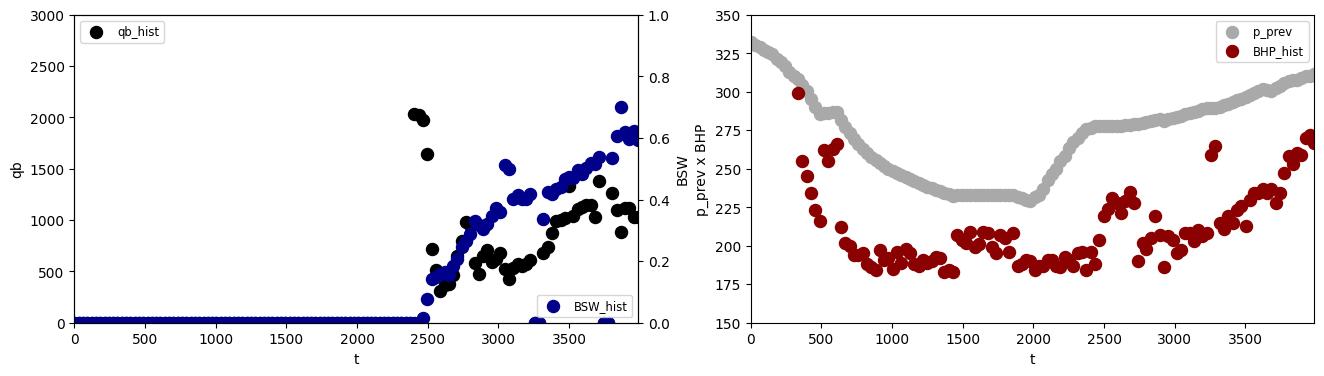

In [4046]:
## Gráfico de Qb, BSW e BHP - Poço

w_num = 1

BHPPw = wells_prod_hist[w_num]["BHP"].values

qbw_hist = np.zeros(len(t))
BSWw = np.zeros(len(t))
for i in range(len(t)):
  qbw_hist[i]=qow[i]+qww[i]
  if (qow[i]+qww[i]) == 0:
    BSWw[i]=0
  else:
    BSWw[i]=qww[i]/(qow[i]+qww[i])


## Dimensionamento do gráfico
plt.figure(figsize=(16, 4))

# Criar subplot de Qb
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(t, qbw_hist, label="qb_hist", color="black", s=75)
ax1.set_xlabel("t")
ax1.set_ylabel("qb")
ax1.set_xlim(0, df.iloc[-1, 6])
ax1.set_ylim(0, 3000)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BSW compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, BSWw, label="BSW_hist", color="darkblue", s=75)
ax2.set_ylabel("BSW")
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

# Subplot para BHP
ax3 = plt.subplot(1, 2, 2)
ax3.scatter(t, p_prev, label="p_prev", color="darkgrey", s=75)
ax3.scatter(t, BHPPw, label="BHP_hist", color="darkred", s=75)
ax3.set_xlabel("t")
ax3.set_ylabel("p_prev x BHP")
ax3.set_xlim(0, df.iloc[-1, 6])
ax3.set_ylim(150, 350)
ax3.legend(fontsize='small')

plt.show()

### Condições Operacionais

In [4047]:
## Definição dos Poços e Condições Operacionais

wells_op=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_wells_operation.xlsx').iloc[:,:-2]
wells_op

,well,type,q_lim,bhp_lim
0,NA1A,prod,2000,190
1,NA2,prod,2000,190
2,NA3D,prod,2000,190
3,RJS19,prod,2000,190
4,PROD005,prod,2000,190
5,PROD008,prod,2000,190
6,PROD009,prod,2000,190
7,PROD010,prod,2000,190
8,PROD012,prod,2000,190
9,PROD014,prod,2000,190


In [4048]:
wells_prod_op = wells_op[wells_op['type'] == 'prod']
wells_prod_op

,well,type,q_lim,bhp_lim
0,NA1A,prod,2000,190
1,NA2,prod,2000,190
2,NA3D,prod,2000,190
3,RJS19,prod,2000,190
4,PROD005,prod,2000,190
5,PROD008,prod,2000,190
6,PROD009,prod,2000,190
7,PROD010,prod,2000,190
8,PROD012,prod,2000,190
9,PROD014,prod,2000,190


In [4049]:
Qbmax = wells_prod_op["q_lim"].values
BHPPmin_op = wells_prod_op["bhp_lim"].values

In [4050]:
wells_inj_op = wells_op[wells_op['type'] == 'inj']
wells_inj_op

,well,type,q_lim,bhp_lim
14,INJ003,inj,5000,350
15,INJ005,inj,5000,350
16,INJ006,inj,5000,350
17,INJ007,inj,5000,350
18,INJ010,inj,5000,350
19,INJ015,inj,5000,350
20,INJ017,inj,5000,350
21,INJ019,inj,5000,350
22,INJ021,inj,5000,350
23,INJ022,inj,5000,350


In [4051]:
Qwimax = wells_inj_op["q_lim"].values
BHPImax_op = wells_inj_op["bhp_lim"].values

In [4052]:
## Limites do sistema

group_lim=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_group_limits.xlsx')
group_lim

,system,limit
0,liquid,15500
1,oil,15500
2,water_prod,13950
3,water_inj,21700
4,gas,2000000


In [4053]:
topside_lim=group_lim['limit'].values
topside_lim

array([  15500,   15500,   13950,   21700, 2000000])

### Dataframes Forecast

In [4054]:
date=df["Date"].values
date_time=pd.to_datetime(date)
date_time

DatetimeIndex(['2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', length=132, freq=None)

In [4055]:
from pandas.tseries.offsets import MonthEnd

# Última data fornecida
last_date = date_time[-1]

# Quantidade de meses na previsão
n_months = 120

# Gerar novas datas, no último dia de cada mês seguinte
new_dates = pd.to_datetime([last_date + MonthEnd(n) for n in range(1, n_months+1)])
new_dates

# (new_dates[0]-date_time[-1]).days

DatetimeIndex(['2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31',
               ...
               '2033-08-31', '2033-09-30', '2033-10-31', '2033-11-30',
               '2033-12-31', '2034-01-31', '2034-02-28', '2034-03-31',
               '2034-04-30', '2034-05-31'],
              dtype='datetime64[ns]', length=120, freq=None)

In [4056]:
## Forecast Dataframe

fc = pd.DataFrame(new_dates, columns=['Date'])
fc = pd.concat([df, fc], ignore_index=True).fillna(0)
fc["t"] = (fc["Date"]-fc["Date"].iloc[0]).astype("int64")/10**9/60/60/24
fc["dt"]=fc["t"].diff().fillna(0)
fc.tail()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,P_prev,So,Sw,Sg,We_ebm,We_aqui,Pa_med,cct,Vpp,RAO
247,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,2034-05-31,0.0,0.0,0.0,0.0,0.0,7640.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4057]:
fc_train = fc.copy()

p_fc=fc_train["Press"].values
npp_fc=fc_train["Np"].values
gp_fc=fc_train["Gp"].values
wp_fc=fc_train["Wp"].values
winj_fc=fc_train["Winj"].values
t_fc=fc_train["t"].values
dt_fc=fc_train["dt"].values
qo_fc=fc_train["qo"].values
qg_fc=fc_train["qg"].values
qw_fc=fc_train["qw"].values
qwi_fc=fc_train["qwi"].values
bo_fc=fc_train["Bo"].values
bg_fc=fc_train["Bg"].values
rs_fc=fc_train["Rs"].values
rp_fc=fc_train["Rp"].values
f_fc=fc_train["F"].values
eo_fc=fc_train["Eo"].values
eg_fc=fc_train["Eg"].values
efw_fc=fc_train["Efw"].values
p_prev_fc=fc_train["P_prev"].values
so_fc=fc_train["So"].values
sw_fc=fc_train["Sw"].values
sg_fc=fc_train["Sg"].values
we_ebm_fc=fc_train["We_ebm"].values
wen_fc=fc_train["We_aqui"].values
pa_med_fc=fc_train["Pa_med"].values
cct_fc=fc_train["cct"].values
Vpp_fc=fc_train["Vpp"].values
uo_fc=fc_train["Viso"].values
ug_fc=fc_train["Visg"].values

# fc_train.iloc[df.shape[0]-2:df.shape[0]+1,5:25]

In [4058]:
## Forecast Dataframe - Wells Prod

wells_prod_fc = []

for i in range(len(wells_prod)):
  wells_prod_fc.append(pd.DataFrame(new_dates, columns=['Date']))
  wells_prod_fc[i].insert(0, 'well', wells_prod[i])
  wells_prod_fc[i] = pd.concat([wells_prod_hist[i], wells_prod_fc[i]], ignore_index=True).fillna(0)
  wells_prod_fc[i]["t"] = (wells_prod_fc[i]["Date"]-wells_prod_fc[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_prod_fc[i]["dt"] = wells_prod_fc[i]["t"].diff().fillna(0)

wells_prod_fc[-1].tail()
# wells_prod_fc[0]["RAO"].iloc[-1]

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi,RAO
247,PROD025A,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0,0.0,0.0,0.0,0.0,0.0
248,PROD025A,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0,0.0,0.0,0.0,0.0,0.0
249,PROD025A,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0,0.0,0.0,0.0,0.0,0.0
250,PROD025A,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0,0.0,0.0,0.0,0.0,0.0
251,PROD025A,2034-05-31,0.0,0.0,0.0,0.0,0.0,7640.0,31.0,0.0,0.0,0.0,0.0,0.0


In [4059]:
## Forecast Dataframe - Wells Inj

wells_inj_fc = []

for i in range(len(wells_inj)):
  wells_inj_fc.append(pd.DataFrame(new_dates, columns=['Date']))
  wells_inj_fc[i].insert(0, 'well', wells_inj[i])
  wells_inj_fc[i] = pd.concat([wells_inj_hist[i], wells_inj_fc[i]], ignore_index=True).fillna(0)
  wells_inj_fc[i]["t"] = (wells_inj_fc[i]["Date"]-wells_inj_fc[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_inj_fc[i]["dt"]=wells_inj_fc[i]["t"].diff().fillna(0)

wells_inj_fc[-1].tail()

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
247,INJ023,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0,0.0,0.0,0.0,0.0
248,INJ023,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0,0.0,0.0,0.0,0.0
249,INJ023,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0,0.0,0.0,0.0,0.0
250,INJ023,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0,0.0,0.0,0.0,0.0
251,INJ023,2034-05-31,0.0,0.0,0.0,0.0,0.0,7640.0,31.0,0.0,0.0,0.0,0.0


In [4060]:
qow_fc = []
qgw_fc = []
qww_fc = []
qwiw_fc = []
RAO_fc = []
nppw_fc = []
BHPP_fc = []
BHPI_fc = []
qbw_fc = []

for i in range(len(wells_prod)):
  qow_fc.append(wells_prod_fc[i]["qo"].values)
  qgw_fc.append(wells_prod_fc[i]["qg"].values)
  qww_fc.append(wells_prod_fc[i]["qw"].values)
  RAO_fc.append(wells_prod_fc[i]["RAO"].values)
  nppw_fc.append(wells_prod_fc[i]["Np"].values)
  BHPP_fc.append(wells_prod_fc[i]["BHP"].values)
  qbw_fc.append(wells_prod_fc[i]["qo"].values+wells_prod_fc[i]["qw"].values)

for j in range(len(wells_inj)):
  qwiw_fc.append(wells_inj_fc[j]["qwi"].values)
  BHPI_fc.append(wells_inj_fc[j]["BHP"].values)

# RAO_fc[-1][:], nppw_fc[-1][:]

### Modelo de Programação Linear

In [4061]:
## SIMPLEX

# warnings.filterwarnings("ignore", category=DeprecationWarning)
print(f"BHPP antes = {BHPP}")

def model_lp_simplex(n, P_lp, bo_lp, bg_lp):
  RAOm = np.zeros(len(wells_prod))
  RGOm = np.zeros(len(wells_prod))
  Btm = np.zeros(len(wells_prod))
  BHPPmin_qb = np.zeros(len(wells_prod))
  BHPPmin = np.zeros(len(wells_prod))
  BHPImax_qwi = np.zeros(len(wells_inj))
  BHPImax = np.zeros(len(wells_inj))

  c = []
  A_ub = []
  A_eq = []
  A_ebm = []
  A_reinj = []
  A_liq = []
  A_inj = []
  b_ub = []
  b_eq = []
  b_ebm = 0
  b_reinj = 0
  b_liq = topside_lim[0]
  b_inj = topside_lim[3]
  bounds = []

  for i in range(len(wells_prod)):
    RAOm[i]=10**(aw[i]/10**6*(nppw_fc[i][df.shape[0]+n-1]-nppw_fc[i][df.shape[0]+n-2])+np.log10(RAO_fc[i][df.shape[0]+n-1]))
    RGOm[i]=Rsi
    # c.append((1+RAOm[i])/RAO[i]/IP[i]) ## Função Objetivo
    c.append((1+RAOm[i])/RAO[i]) ## Função Objetivo (BSW)

    if (i == 8) or (i == 13):
      bounds.append((P_lp-50, P_lp-50))
    else:
      # BHPPmin_qb[i]=P_lp-Qbmax[i]/IP[i]
      # BHPPmin[i]=max(BHPPmin_op[i], BHPPmin_qb[i])
      # bounds.append((BHPPmin[i], P_lp-25))
      # bounds.append((BHPP[i]-10, P_lp))
      bounds.append((BHPP[i]-10, min(BHPP[i]+10, P_lp-10)))

    Btm[i] = (bo_lp+RGOm[i]*bg_lp+RAOm[i]*Bw)/(1+RAOm[i])
    # A_ebm.append(Btm[i]*IP[i])
    # b_ebm += Btm[i]*IP[i]*P_lp
    A_ebm.append(-IP[i])
    b_ebm -= IP[i]*P_lp

    A_inj.append(0)
    b_inj+=0

    A_liq.append(-IP[i])
    b_liq-=IP[i]*P_lp

    # A_reinj.append(-RAOm[i]*IP[i]/(1+RAOm[i]))
    # b_reinj += -RAOm[i]*IP[i]/(1+RAOm[i])*P_lp

  for j in range(len(wells_inj)):
    c.append(0) ## Função Objetivo

    BHPImax_qwi[j]=P_lp+Qwimax[j]/II[j]
    BHPImax[j]=min(BHPImax_op[j], BHPImax_qwi[j])
    bounds.append((P_lp, BHPImax[j]))
    # bounds.append((BHPImax_op[j], BHPImax_op[j]))

    # A_ebm.append(Bw*II[j])
    # A_ebm.append(0)
    # b_ebm += Bw*II[j]*P_lp
    A_ebm.append(-II[j])
    b_ebm -= II[j]*P_lp

    A_inj.append(II[j])
    b_inj += II[j]*P_lp

    A_liq.append(0)
    b_liq-=0

    # A_reinj.append(-II[j])
    # b_reinj += -II[j]*P_lp

  # A_eq.append(A_ebm)
  # b_eq.append(b_ebm)
  A_ub.append(A_ebm)
  b_ub.append(b_ebm)
  A_ub.append(A_inj)
  b_ub.append(b_inj)
  A_ub.append(A_liq)
  b_ub.append(b_liq)
  # A_ub.append(A_reinj)
  # b_ub.append(b_reinj)

  # bounds[0] = (190, 190) ## Ajuste manual poço 0
  # bounds[2] = (190, 190) ## Ajuste manual poço 2
  # bounds[3] = (190, 190) ## Ajuste manual poço 3
  # bounds[7] = (190, 190) ## Ajuste manual poço 11

  print(bounds)

  result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs-ds')
  # result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs-ds')
  # result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs-ds')

  # print("Resultado da Otimização:")
  print("Status:", result.message)
  # if result.success:
  #     print(f"BHPs escolhidos: {result.x:}")
  #     print(f"Custo mínimo: {result.fun:.2f}")

  return result.x[0:len(wells_prod)], result.x[len(wells_prod):]

# topside_lim[3]
# BHPP_d, BHPI_d = model_lp_simplex(0, p_prev_fc[df.shape[0]+0-1], bo_fc[df.shape[0]+0-1], bg_fc[df.shape[0]+0-1])
# print(f"BHPP depois = {BHPP_d}")
# print(f"dBHPP = {BHPP_d-BHPP}")

BHPP antes = [228.         267.         190.         195.         258.
 289.         239.         300.         261.50907795 217.
 292.         185.         246.         261.50907795]


In [4062]:
# ## CPLEX - CONFIGURAR

# # warnings.filterwarnings("ignore", category=DeprecationWarning)
# print(f"BHPP antes = {BHPP}")

# n=0
# P_pl=p_prev_fc[df.shape[0]+0-1]
# RAOm = np.zeros(len(wells_prod))
# RGOm = np.zeros(len(wells_prod))

# m = Model(name='model_lp_cplex')

# # Variáveis de decisão (BHP de cada poço)
# BHPP_lp = m.continuous_var_list(len(wells_prod), name='BHPP_lp')
# # BHPI_lp = m.continuous_var_list(len(wells_inj), name='BHPI_lp')

# # Restrições
# for i in range(len(wells_prod)):
#   m.add_constraint(BHPP_lp[i] >= BHPPmin_op[i])
#   m.add_constraint(BHPP_lp[i] <= P_pl)
# # m.add_constraint()

# # Função objetivo
# custo_total = 0
# for i in range(len(wells_prod)):
#   RAOm[i]=10**(aw[i]/10**6*(nppw_fc[i][df.shape[0]+n-1]-nppw_fc[i][df.shape[0]+n-2])+np.log10(RAO_fc[i][df.shape[0]+n-1]))
#   RGOm[i]=Rsi
#   custo_total += IP[i]*(P_pl-BHPP_lp[i])*(1+RGOm[i])/(1+RAOm[i])
# # m.maximize(custo_total)

# # Solução
# sol = m.solve()


# # # BHPP_d, BHPI_d = model_lp(0, p_prev_fc[df.shape[0]+0-1], bo_fc[df.shape[0]+0-1], bg_fc[df.shape[0]+0-1])
# # # print(f"BHPP depois = {BHPP_d}")
# # # print(f"dBHPP = {BHPP_d-BHPP}")

### Execução da Previsão

In [4063]:
## Forecast

for n in range(n_months):
  ## Previsão de vazões
  # RAO = uo_fc[df.shape[0]+n-1]*f_krw(sw_fc[df.shape[0]+n-1], nw)*bo_fc[df.shape[0]+n-1]/(uw*f_krow(sw_fc[df.shape[0]+n-1], now)*Bw)*90
  # RAO_fc = 10**(a*(npp_fc[df.shape[0]+n-1]-npp_fc[df.shape[0]+n-2])+np.log10(qw_fc[df.shape[0]+n-1]/qo_fc[df.shape[0]+n-1]))
  # RGO_fc = uo_fc[df.shape[0]+n-1]*f_krg(sg_fc[df.shape[0]+n-1], ng)*bo_fc[df.shape[0]+n-1]/(ug_fc[df.shape[0]+n-1]*f_krog(sg_fc[df.shape[0]+n-1], nog)*bg_fc[df.shape[0]+n-1])+rs_fc[df.shape[0]+n-1]
  # print(RGO_fc)
  RGO = Rsi

  ## Modelo de programação linear
  BHPP, BHPI = model_lp_simplex(n, p_prev_fc[df.shape[0]+n-1], bo_fc[df.shape[0]+n-1], bg_fc[df.shape[0]+n-1])

  ## Cálculo das vazões

  ## Produtores
  for i in range(len(wells_prod)):
    RAO_fc[i][df.shape[0]+n]=10**(aw[i]/10**6*(nppw_fc[i][df.shape[0]+n-1]-nppw_fc[i][df.shape[0]+n-2])+np.log10(RAO_fc[i][df.shape[0]+n-1]))
    # RAO_fc[i][df.shape[0]+n]=RAOm[i]
    # print(RAO_fc[i][df.shape[0]+n])

    # IP=wells_prod_op[wells_prod_op["well"]==wells_prod[i]].values[0][-1]
    # BHPP=wells_prod_op[wells_prod_op["well"]==wells_prod[i]].values[0][-2]
    IP_fc=IP[i]
    BHPP_fc[i][df.shape[0]+n]=BHPP[i] # BHP Constante

    # Vazão do poço
    qbw_fc[i][df.shape[0]+n]=IP_fc*(p_prev_fc[df.shape[0]+n-1]-BHPP_fc[i][df.shape[0]+n])
    # print(qb)
    qow_fc[i][df.shape[0]+n]=qbw_fc[i][df.shape[0]+n]/(1+RAO_fc[i][df.shape[0]+n])
    # print(qo_fc[i][df.shape[0]+n])
    qgw_fc[i][df.shape[0]+n]=qow_fc[i][df.shape[0]+n]*RGO
    qww_fc[i][df.shape[0]+n]=qow_fc[i][df.shape[0]+n]*RAO_fc[i][df.shape[0]+n]

    # Acumulada do poço
    nppw_fc[i][df.shape[0]+n]=nppw_fc[i][df.shape[0]+n-1]+qow_fc[i][df.shape[0]+n]*dt_fc[df.shape[0]+n]

    # Vazões do campo
    qo_fc[df.shape[0]+n]+=qow_fc[i][df.shape[0]+n]
    qg_fc[df.shape[0]+n]+=qgw_fc[i][df.shape[0]+n]
    qw_fc[df.shape[0]+n]+=qww_fc[i][df.shape[0]+n]

  ## Injetores
  for j in range(len(wells_inj)):
    # II=wells_inj_op[wells_inj_op["well"]==wells_inj[j]].values[0][-1]
    # BHPI=wells_inj_op[wells_inj_op["well"]==wells_inj[j]].values[0][-2]
    II_fc = II[j]
    BHPI_fc[j][df.shape[0]+n]=BHPI[j]

    # Vazão do poço
    qwiw_fc[j][df.shape[0]+n]=II_fc*(BHPI_fc[j][df.shape[0]+n]-p_prev_fc[df.shape[0]+n-1])
    # qwiw_fc[j][df.shape[0]+n]=qwiw_fc[j][df.shape[0]+n-1] ## Qwi constante

    # Vazão do campo
    qwi_fc[df.shape[0]+n]+=qwiw_fc[j][df.shape[0]+n]

  ## Controle dos poços -> aumentar a quantidade de produtores e injetores, por enquanto o problema está sendo tratado como 1P+1I
  # if p_prev_fc[df.shape[0]+n-1] < p_fc[0]:
  #   BHPP[n]=100
    # BHPI[n]=450
  # else: ## Estimar usando programação linear -> implementar modelo
  #   BHPP[n]=BHPP[n-1]*1.
  #   BHPI[n]=BHPI[n-1]*1.0

  ## Previsão de acumuladas - Campo
  npp_fc[df.shape[0]+n]=npp_fc[df.shape[0]+n-1]+qo_fc[df.shape[0]+n]*dt_fc[df.shape[0]+n]
  gp_fc[df.shape[0]+n]=gp_fc[df.shape[0]+n-1]+qg_fc[df.shape[0]+n]*dt_fc[df.shape[0]+n]
  wp_fc[df.shape[0]+n]=wp_fc[df.shape[0]+n-1]+qw_fc[df.shape[0]+n]*dt_fc[df.shape[0]+n]
  winj_fc[df.shape[0]+n]=winj_fc[df.shape[0]+n-1]+qwi_fc[df.shape[0]+n]*dt_fc[df.shape[0]+n]
  rp_fc[df.shape[0]+n]=gp_fc[df.shape[0]+n]/npp_fc[df.shape[0]+n]

  # Previsão de pressão
  def obj_f(x, m, N, Wei, J):
    pn = x[0]  # pressao prevista

    ## Aquifero
    pa_med_fc[df.shape[0]+n-1]=p_fc[0]*(1-(wen_fc[df.shape[0]+n-1]/Wei))
    wen_fc[df.shape[0]+n]=wen_fc[df.shape[0]+n-1]+(Wei/p_fc[0])*(pa_med_fc[df.shape[0]+n-1]-pn)*(1-np.exp(-J*p_fc[0]*dt_fc[df.shape[0]+n]/Wei))

    ## EBM
    if pn < pb:
      bo_fc[df.shape[0]+n] = bo_a * pn + bo_b
      rs_fc[df.shape[0]+n] = rs_a * pn + rs_b
    else:
      bo_fc[df.shape[0]+n] = bob - co * (pn - pb)
      rs_fc[df.shape[0]+n] = Rsi
    bg_fc[df.shape[0]+n] = bg_a*pn**(bg_b)
    f_fc[df.shape[0]+n]=npp_fc[df.shape[0]+n]*(bo_fc[df.shape[0]+n]+(rp_fc[df.shape[0]+n]-rs_fc[df.shape[0]+n])*bg_fc[df.shape[0]+n])+(wp_fc[df.shape[0]+n]-winj_fc[df.shape[0]+n])*Bw

    eo_fc[df.shape[0]+n]=bo_fc[df.shape[0]+n]-bo_fc[0]+(Rsi-rs_fc[df.shape[0]+n])*bg_fc[df.shape[0]+n]
    eg_fc[df.shape[0]+n]=bo_fc[0]*((bg_fc[df.shape[0]+n]/bg_fc[0])-1)
    efw_fc[df.shape[0]+n]=(1+m)*bo_fc[0]*((cf+cw*Swi)/(1-Swi))*(p_fc[0]-pn)
    we_ebm_fc[df.shape[0]+n]=f_fc[df.shape[0]+n]-N*(eo_fc[df.shape[0]+n]+m*eg_fc[df.shape[0]+n]+efw_fc[df.shape[0]+n])*10**6
    return (we_ebm_fc[df.shape[0]+n] - wen_fc[df.shape[0]+n]) ** 2
  x0 = [p_prev_fc[df.shape[0]+n-1]]
  result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))

  p_prev_fc[df.shape[0]+n]=result.x[0]
  pa_med_fc[df.shape[0]+n]=p_fc[0]*(1-(wen_fc[df.shape[0]+n]/Wei_est))

  ## Previsão de saturações
  cct_fc[df.shape[0]+n] = (1 + (Swi * cw / (1 - Swi) + cf) * (p_prev_fc[df.shape[0]+n] - p_fc[0]))
  Vpp_fc[df.shape[0]+n] = Vp * (1 + cf * (p_prev_fc[df.shape[0]+n] - p_fc[0]))
  so_fc[df.shape[0]+n] = ((N_est*10**6) - npp_fc[df.shape[0]+n]) *bo_fc[0] / Vpp_fc[df.shape[0]+n]
  sw_fc[df.shape[0]+n] = (Swi * Vp * (1 - cw * (p_prev_fc[df.shape[0]+n] - p_fc[0])) + ((winj_fc[df.shape[0]+n] - wp_fc[df.shape[0]+n] + wen_fc[df.shape[0]+n]) * Bw)) / Vpp_fc[df.shape[0]+n]
  sg_fc[df.shape[0]+n] = bg_fc[df.shape[0]+n] * (G - gp_fc[df.shape[0]+n] - ((N_est*10**6) - npp_fc[df.shape[0]+n]) * rs_fc[df.shape[0]+n] - cct_fc[df.shape[0]+n] * m * (N_est*10**6) * bo_fc[0] / bg_fc[0]) / Vpp_fc[df.shape[0]+n]

  ## Previsão de viscosidades
  uo_fc[df.shape[0]+n]=viso_a*np.log(p_prev_fc[df.shape[0]+n])+viso_b
  ug_fc[df.shape[0]+n]=visg_a*p_prev_fc[df.shape[0]+n]+visg_b

fc_train.iloc[df.shape[0]-1:fc.shape[0],:20]

[(218.0, 238.0), (257.0, 277.0), (180.0, 200.0), (185.0, 205.0), (248.0, 268.0), (279.0, 299.0), (229.0, 249.0), (290.0, 301.50907795214516), (261.50907795214516, 261.50907795214516), (207.0, 227.0), (282.0, 301.50907795214516), (175.0, 195.0), (236.0, 256.0), (261.50907795214516, 261.50907795214516), (311.50907795214516, 350.0), (311.50907795214516, 350.0), (311.50907795214516, 350.0), (311.50907795214516, 350.0), (311.50907795214516, 350.0), (311.50907795214516, 350.0), (311.50907795214516, 344.8424112854785), (311.50907795214516, 350.0), (311.50907795214516, 350.0), (311.50907795214516, 350.0), (311.50907795214516, 350.0)]
Status: Optimization terminated successfully. (HiGHS Status 7: Optimal)
[(217.44810923812506, 237.44810923812506), (247.0, 267.0), (170.0, 190.0), (175.0, 195.0), (238.0, 258.0), (269.0, 289.0), (239.0, 259.0), (280.0, 300.0), (263.69804038576297, 263.69804038576297), (197.0, 217.0), (291.50907795214516, 303.69804038576297), (165.0, 185.0), (226.0, 246.0), (263.69

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi,Bo,Bg,Rs,Viso,Visg,Rp,F,Eo
131,2024-05-31,309.0,2.583242e+07,2.913899e+09,5.206739e+06,3.934119e+07,3988.0,31.0,8549.000000,973332.000000,6933.000000,20607.000000,1.397967,0.003506,113.06,0.686348,0.026071,112.800080,1.238051e+06,0.003726
132,2024-06-30,0.0,2.608239e+07,2.942160e+09,5.421770e+06,3.998478e+07,4018.0,30.0,8332.310112,942050.981246,7167.689888,21452.863259,1.397206,0.003450,113.06,0.676246,0.026331,112.802571,1.130467e+06,0.002965
133,2024-07-31,0.0,2.632924e+07,2.970069e+09,5.655419e+06,4.062081e+07,4049.0,31.0,7962.913791,900287.033255,7537.086209,20517.195894,1.397030,0.003438,113.06,0.673938,0.026391,112.804985,1.059998e+06,0.002789
134,2024-08-31,0.0,2.656355e+07,2.996560e+09,5.901612e+06,4.124249e+07,4080.0,31.0,7558.292998,854540.606326,7941.707002,20054.153497,1.396882,0.003427,113.06,0.672000,0.026441,112.807234,1.000104e+06,0.002642
135,2024-09-30,0.0,2.677766e+07,3.020768e+09,6.152493e+06,4.183241e+07,4110.0,30.0,7137.304167,806943.609088,8362.695833,19664.008054,1.396758,0.003418,113.06,0.670377,0.026484,112.809255,9.497793e+05,0.002517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2034-01-31,0.0,3.225030e+07,3.639505e+09,5.353485e+07,9.705989e+07,7520.0,31.0,883.853644,99928.492976,14616.146356,15827.616485,1.395765,0.003350,113.06,0.657529,0.026823,112.851805,5.522876e+05,0.001524
248,2034-02-28,0.0,3.227497e+07,3.642294e+09,5.394419e+07,9.750303e+07,7548.0,28.0,881.001162,99605.991332,14618.998838,15826.534117,1.395765,0.003350,113.06,0.657525,0.026823,112.851964,5.521887e+05,0.001524
249,2034-03-31,0.0,3.230220e+07,3.645373e+09,5.439745e+07,9.799363e+07,7579.0,31.0,878.451368,99317.711702,14621.548632,15825.564620,1.395764,0.003350,113.06,0.657521,0.026823,112.852139,5.520804e+05,0.001523
250,2034-04-30,0.0,3.232847e+07,3.648343e+09,5.483618e+07,9.846836e+07,7609.0,30.0,875.655743,99001.638257,14624.344257,15824.505848,1.395764,0.003350,113.06,0.657518,0.026823,112.852308,5.519766e+05,0.001523


### Gráficos

#### Campo

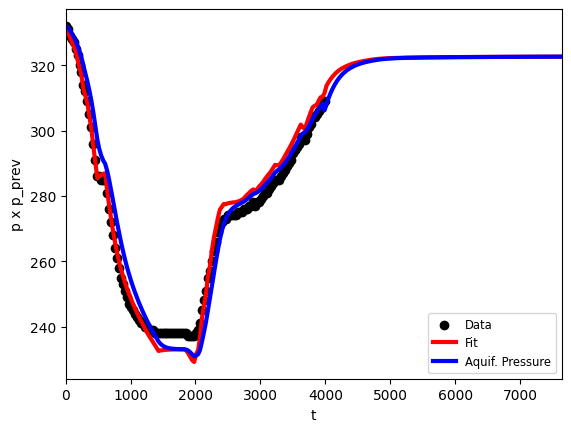

In [4064]:
## Gráfico de pressões

plt.scatter(t, p, label="Data", color="black")
plt.plot(t_fc, p_prev_fc, label=f"Fit", color="red", linewidth=3)
plt.plot(t_fc, pa_med_fc, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, fc.iloc[-1, 6])
plt.show()

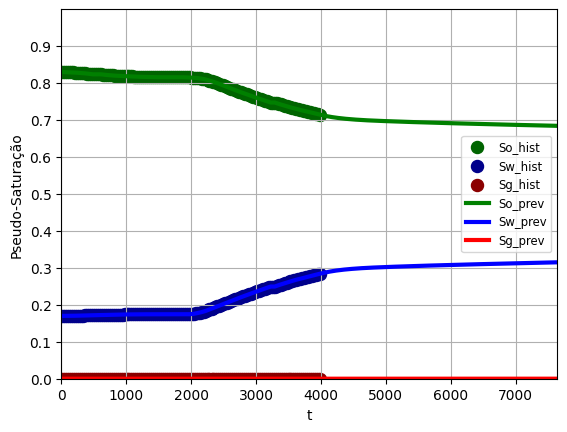

In [4065]:
## Gráfico de saturações

fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.scatter(t, So, label="So_hist", color="darkgreen", s=75)
plt.scatter(t, Sw, label="Sw_hist", color="darkblue", s=75)
plt.scatter(t, Sg, label="Sg_hist", color="darkred", s=75)
plt.plot(t_fc, so_fc, label="So_prev", color="green", linewidth=3)
plt.plot(t_fc, sw_fc, label="Sw_prev", color="blue", linewidth=3)
plt.plot(t_fc, sg_fc, label="Sg_prev", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, fc.iloc[-1, 6])
plt.show()

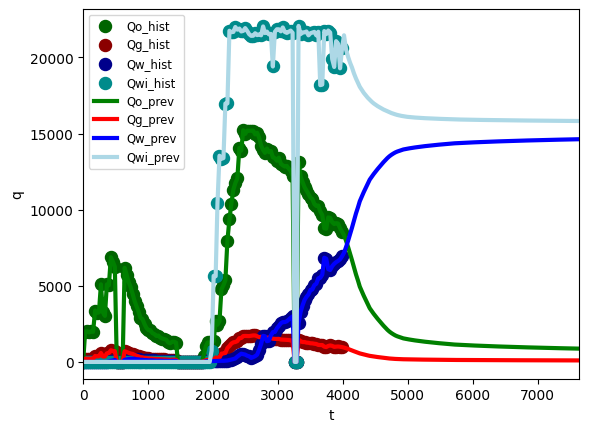

In [4066]:
## Gráfico de vazões

plt.scatter(t, qo, label="Qo_hist", color="darkgreen", s=75)
plt.scatter(t, qg/1000, label="Qg_hist", color="darkred", s=75)
plt.scatter(t, qw, label="Qw_hist", color="darkblue", s=75)
plt.scatter(t, qwi, label="Qwi_hist", color="darkcyan", s=75)
plt.plot(t_fc, qo_fc, label=f"Qo_prev", color="green", linewidth=3)
plt.plot(t_fc, qg_fc/1000, label=f"Qg_prev", color="red", linewidth=3)
plt.plot(t_fc, qw_fc, label=f"Qw_prev", color="blue", linewidth=3)
plt.plot(t_fc, qwi_fc, label=f"Qwi_prev", color="lightblue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("q")
plt.xlim(0, fc.iloc[-1, 6])
plt.show()

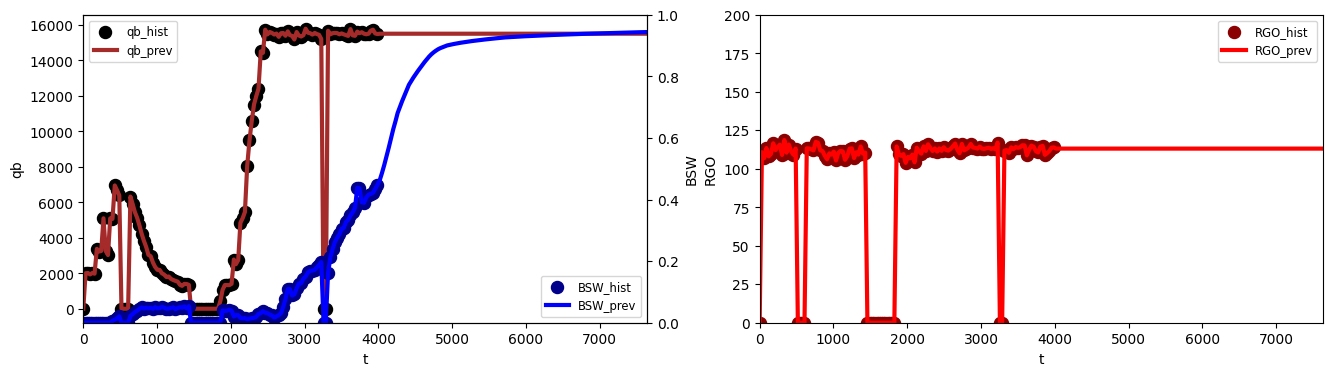

In [4067]:
## Gráficos de Qb, BSW e RGO - Campo

qb_hist = np.zeros(len(t))
RGO = np.zeros(len(t))
BSW = np.zeros(len(t))
for i in range(len(t)):
  qb_hist[i]=qo[i]+qw[i]
  if qo[i] == 0:
    RGO[i]=0
  else:
    RGO[i]=qg[i]/qo[i]
  if (qo[i]+qw[i]) == 0:
    BSW[i]=0
  else:
    BSW[i]=qw[i]/(qo[i]+qw[i])

qb_fc = np.zeros(len(t_fc))
RGO_fc = np.zeros(len(t_fc))
BSW_fc = np.zeros(len(t_fc))
for i in range(len(t_fc)):
  qb_fc[i]=qo_fc[i]+qw_fc[i]
  if qo_fc[i] == 0:
    RGO_fc[i]=0
  else:
    RGO_fc[i]=qg_fc[i]/qo_fc[i]
  if (qo_fc[i]+qw_fc[i]) == 0:
    BSW_fc[i]=0
  else:
    BSW_fc[i]=qw_fc[i]/(qo_fc[i]+qw_fc[i])

## Dimensionamento do gráfico
plt.figure(figsize=(16, 4))

# Subplot para Qb e BSW
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(t, qb_hist, label="qb_hist", color="black", s=75)
ax1.plot(t_fc, qb_fc, label="qb_prev", color="brown", linewidth=3)
ax1.set_xlabel("t")
ax1.set_ylabel("qb")
ax1.set_xlim(0, fc.iloc[-1, 6])
# ax1.set_ylim(0, 20000)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BSW compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, BSW, label="BSW_hist", color="darkblue", s=75)
ax2.plot(t_fc, BSW_fc, label="BSW_prev", color="blue", linewidth=3)
ax2.set_ylabel("BSW")
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

# Subplot para RGO
ax3 = plt.subplot(1, 2, 2)
ax3.scatter(t, RGO, label="RGO_hist", color="darkred", s=75)
ax3.plot(t_fc, RGO_fc, label="RGO_prev", color="red", linewidth=3)
ax3.set_xlabel("t")
ax3.set_ylabel("RGO")
ax3.set_xlim(0, fc.iloc[-1, 6])
ax3.set_ylim(0, 200)
ax3.legend(fontsize='small')

#### Poço

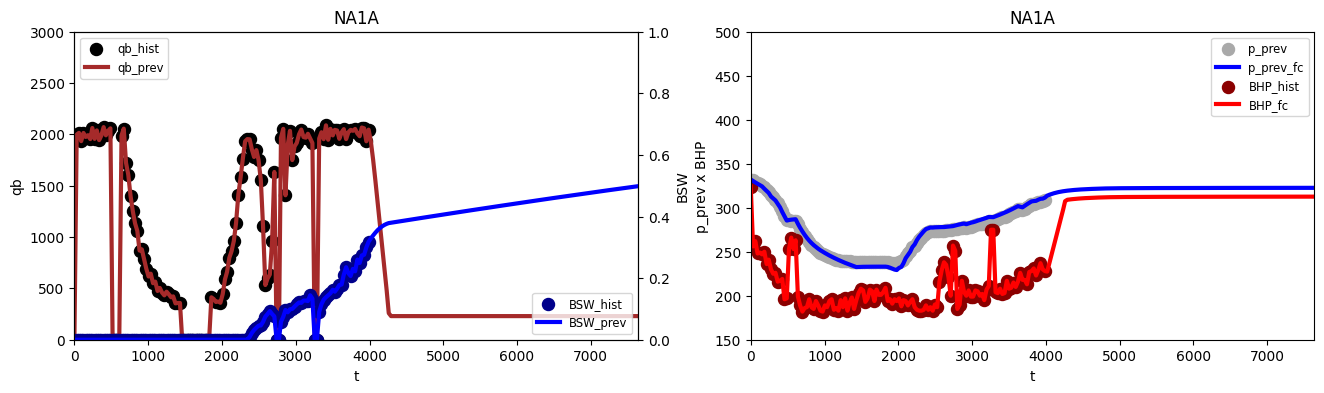

In [4068]:
## Gráfico de Qb, BSW e BHP - Poço

w_num = 0
qbw_hist = np.zeros(len(t))
BSWw = np.zeros(len(t))
BHPPw = np.zeros(len(t))
for i in range(len(t)):
  qbw_hist[i]=qow_fc[w_num][i]+qww_fc[w_num][i]
  BHPPw[i]=BHPP_fc[w_num][i]
  if (qow_fc[w_num][i]+qww_fc[w_num][i]) == 0:
    BSWw[i]=0
  else:
    BSWw[i]=qww_fc[w_num][i]/(qow_fc[w_num][i]+qww_fc[w_num][i])

BSWw_fc = np.zeros(len(t_fc))
for i in range(len(t_fc)):
  if (qow_fc[w_num][i]+qww_fc[w_num][i]) == 0:
    BSWw_fc[i]=0
  else:
    BSWw_fc[i]=qww_fc[w_num][i]/(qow_fc[w_num][i]+qww_fc[w_num][i])

## Dimensionamento do gráfico
plt.figure(figsize=(16, 4))

# Criar subplot de Qb
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(t, qbw_hist, label="qb_hist", color="black", s=75)
ax1.plot(t_fc, qbw_fc[w_num], label="qb_prev", color="brown", linewidth=3)
ax1.set_title(wells_prod[w_num])
ax1.set_xlabel("t")
ax1.set_ylabel("qb")
ax1.set_xlim(0, fc.iloc[-1, 6])
ax1.set_ylim(0, 3000)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BSW compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, BSWw, label="BSW_hist", color="darkblue", s=75)
ax2.plot(t_fc, BSWw_fc, label="BSW_prev", color="blue", linewidth=3)
ax2.set_ylabel("BSW")
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

# Subplot para BHP
ax3 = plt.subplot(1, 2, 2)
ax3.scatter(t, p, label="p_prev", color="darkgrey", s=75)
ax3.plot(t_fc, p_prev_fc, label="p_prev_fc", color="blue", linewidth=3)
ax3.scatter(t, BHPPw, label="BHP_hist", color="darkred", s=75)
ax3.plot(t_fc,BHPP_fc[w_num], label="BHP_fc", color="red", linewidth=3)
ax3.set_title(wells_prod[w_num])
ax3.set_xlabel("t")
ax3.set_ylabel("p_prev x BHP")
ax3.set_xlim(0, fc.iloc[-1, 6])
ax3.set_ylim(150, 500)
ax3.legend(fontsize='small')

plt.show()

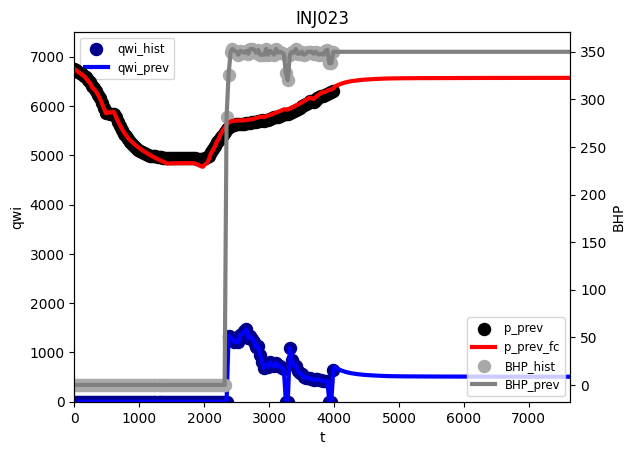

In [4069]:
## Gráfico de Qwi - Poço

wi_num = 10

qwiw_hist = np.zeros(len(t))
BHPIw_hist = np.zeros(len(t))
for i in range(len(t)):
  qwiw_hist[i]=qwiw_fc[wi_num][i]
  BHPIw_hist[i]=BHPI_fc[wi_num][i]

# Criar subplot de Qwi
ax1 = plt.subplot(1, 1, 1)
ax1.scatter(t, qwiw_hist, label="qwi_hist", color="darkblue", s=75)
ax1.plot(t_fc, qwiw_fc[wi_num], label="qwi_prev", color="blue", linewidth=3)
ax1.set_title(wells_inj[wi_num])
ax1.set_xlabel("t")
ax1.set_ylabel("qwi")
ax1.set_xlim(0, fc.iloc[-1, 6])
ax1.set_ylim(0, 7500)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BHP compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, p, label="p_prev", color="black", s=75)
ax2.plot(t_fc, p_prev_fc, label="p_prev_fc", color="red", linewidth=3)
ax2.scatter(t, BHPIw_hist, label="BHP_hist", color="darkgrey", s=75)
ax2.plot(t_fc, BHPI_fc[wi_num], label="BHP_prev", color="grey", linewidth=3)
ax2.set_ylabel("BHP")
# ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

plt.show()